In [33]:
import numpy as np
from scipy import special as spc
from numpy import random as r
from matplotlib import pyplot as plt

In [2]:
sigma = 10
theta = sigma/200
me = 9.10938e-31
c = 3e8
kb = 1.38064852e-23
# theta = kb T / ( m * c**2 )
# T = theta * m * c**2 / kb 
T = theta*me*c**2/kb
def sobol(n):
    u = np.zeros(n)
    for i in range(u.size):
        eta = 0
        while eta**2 - u[i]**2 <= 1:
            x4 = r.rand()                
            x5 = r.rand()                 
            x6 = r.rand()
            u[i] = -T * np.log(x4*x5*x6)     
            x7 = r.rand()                 
            eta = -T * np.log(x4*x5*x6*x7)
    return(u)
def f(u):
    return(np.e**(-(np.sqrt(1+u**2)/T))*u**2)

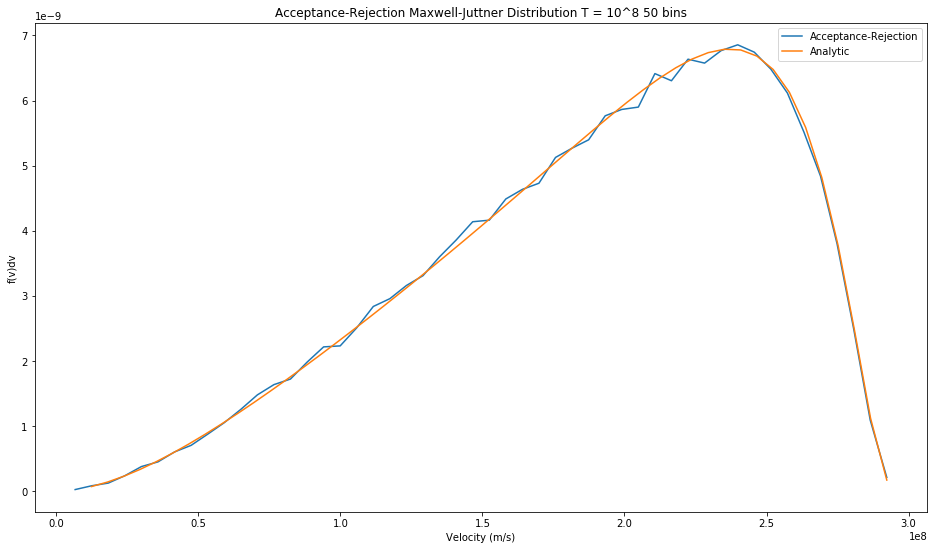

In [3]:
T = 10**8 #Temperature
n = 10**5 #Number of initialized velocities
b = 50 #Histogram Bins
us = sobol(n) #Initialized Velocities
vs = us/np.sqrt(1+us**2/c**2) #Convert u values to v values
cmjd,v1 = np.histogram(vs,bins=b,density=True) #Create a histogram sampling f(v)dv
for i in range(v1.size-1): #This loop finds the midpoint of each bin
    v1[i] =+(v1[i+1]+v1[i])/2
    i += 1
v1 = v1[0:v1.size-1] #The last value of v1 is not a midpoint
v2 = np.arange(min(v1)+(max(v1)-min(v1))/b,max(v1)+(max(v1)-min(v1))/b,(max(v1)-min(v1))/b) #The domain of the analytic f(v)dv is equal to that of the computational f(v)dv 
amjd = f(v2/np.sqrt(1-v2**2/c**2))/np.sqrt(1-v2**2/c**2)**3
#The python function f(u) is a function of u = 1/sqrt(1-v**2/c**2) v**2 and is mathematically equivalent to f(u)du
#We can show that du = gamma**3 dv We multiply by this factor and convert u to v, such that our input looks like f( v/sqrt(1-v**2/c**2) ) * 1/sqrt(1-v**2/c**2)**3
amjd *= 1/(sum(amjd)*(v2[1]-v2[0])) #Normalize the integral of the analytic distribution to be equal to that of the computational distribution.
plt.plot(v1,cmjd); plt.plot(v2,amjd)

plt.title('Acceptance-Rejection Maxwell-Juttner Distribution T = 10^8 50 bins')
plt.gca().set_xlabel('Velocity (m/s)')
plt.gca().set_ylabel('f(v)dv')
plt.gcf().set_facecolor('white')
plt.legend(('Acceptance-Rejection','Analytic'))
plt.gcf().set_size_inches(16,9)

In [70]:
def fxPrimeBoost(ux,beta):
    return( (1/np.sqrt(1-beta**2) * np.sqrt(1+ux**2)+T) * np.e**(-1/np.sqrt(1-beta**2)*(np.sqrt(1+ux**2)-beta*ux)/T))
def sobolxBoost(n,beta):
    u = np.zeros(n)
    for i in range(u.size):
        eta = 0
        x8 = 1
        omega = 0
        while eta**2 - u[i]**2 <= 1:
            x4 = r.rand()                
            x5 = r.rand()                 
            x6 = r.rand()
            u[i] = -T * np.log(x4*x5*x6)     
            x7 = r.rand()                 
            eta = -T * np.log(x4*x5*x6*x7)
        x1 = r.rand()
        u[i] = u[i] * (2*x1 - 1)
        omega = 1/2*(1+beta*u[i]/(np.sqrt(1+u[i]**2)))
        x8 = r.rand()
        if omega < x8:
            u[i] = None
    u = np.delete(u,np.argwhere(np.isnan(u)))
    return(u)
def flippingMethod(n,beta):
    u = np.zeros(n)
    for i in range(u.size):
        eta = 0
        x8 = 1
        omega = 0
        while eta**2 - u[i]**2 <= 1:
            x4 = r.rand()                
            x5 = r.rand()                 
            x6 = r.rand()
            u[i] = -T * np.log(x4*x5*x6)     
            x7 = r.rand()                 
            eta = -T * np.log(x4*x5*x6*x7)
        x1 = r.rand()
        ux = u[i] * (2*x1 - 1)  
        x9 = r.rand()
        if -beta*ux/np.sqrt(1+ux**2) > x9:
            u[i] = -u[i]
        u[i] = 1/np.sqrt(1-beta**2)*(ux + beta*np.sqrt(1+u[i]**2))
    return(u)

In [ ]:
fxPrimeBoost(ux,beta)

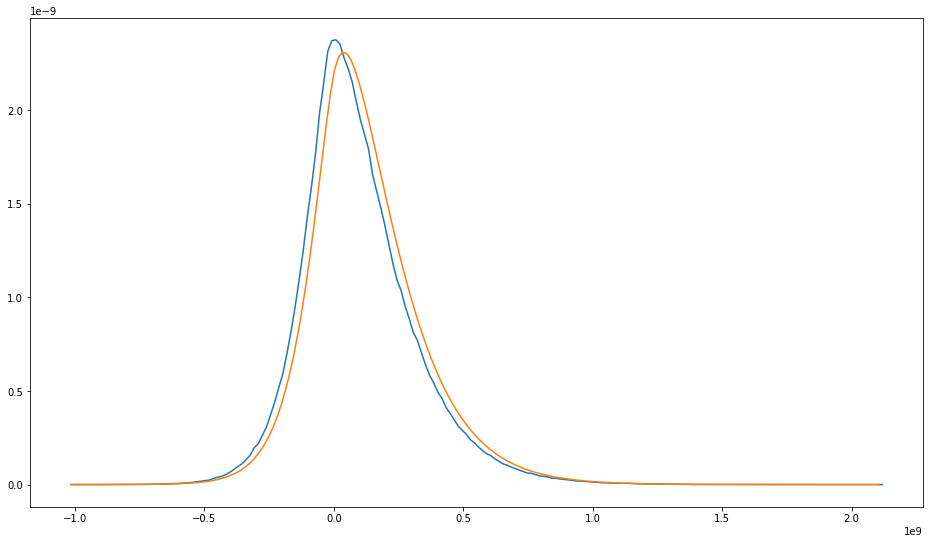

In [71]:
T = 10**8
beta = 0.3
n = 10**6
b = 200
us = flippingMethod(n,beta)
cmjd, u1 = np.histogram(us, bins = b, density = True)
for i in range(u1.size-1):
    u1[i] = (u1[i+1] + u1[i])/2
u1 = u1[0:u1.size-1]
#cmjd = cmjd/max(cmjd)    
plt.plot(u1,cmjd)
u2 = np.arange(min(u1),max(u1),(max(u1)-min(u1))/b)
amjd = fxPrimeBoost(u2,beta)
amjd = amjd/(sum(amjd)*(u2[1]-u2[0]))
#amjd = amjd/max(amjd)
plt.plot(u2,amjd)
plt.gcf().set_facecolor('white')
plt.gcf().set_size_inches(16,9)

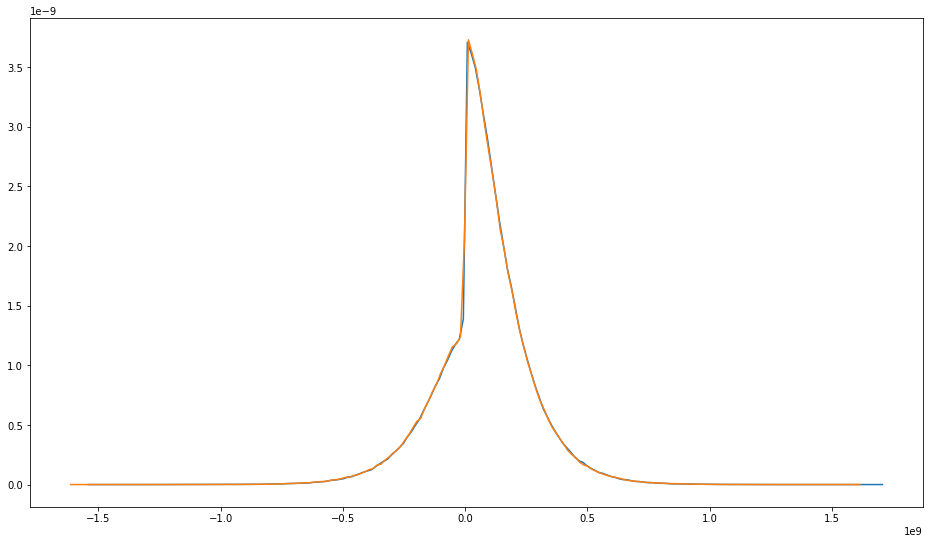

In [26]:
T = 10**8
beta = 0.5
n = 10**6
b = 200
us1 = flippingMethod(n,beta)
cmjd1, u1 = np.histogram(us1, bins = b, density = True)
for i in range(u1.size-1):
    u1[i] = (u1[i+1] + u1[i])/2
u1 = u1[0:u1.size-1]
plt.plot(u1,cmjd1)
us2 = sobolxBoost(n,beta)
cmjd2, u2 = np.histogram(us2, bins = b, density = True)
for i in range(u1.size-1):
    u2[i] = (u2[i+1] + u2[i])/2
u2 = u2[0:u2.size-1]
plt.plot(u2,cmjd2)
plt.gcf().set_facecolor('white')
plt.gcf().set_size_inches(16,9)